In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import tabulate
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [65]:
from app.utils import ImageWrapper
from app.models import Classifier
from app.custom import RemoveBusBars, Orient, BusbarMask
from app.transforms import FFT, IFFT, CreateOnesMask
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

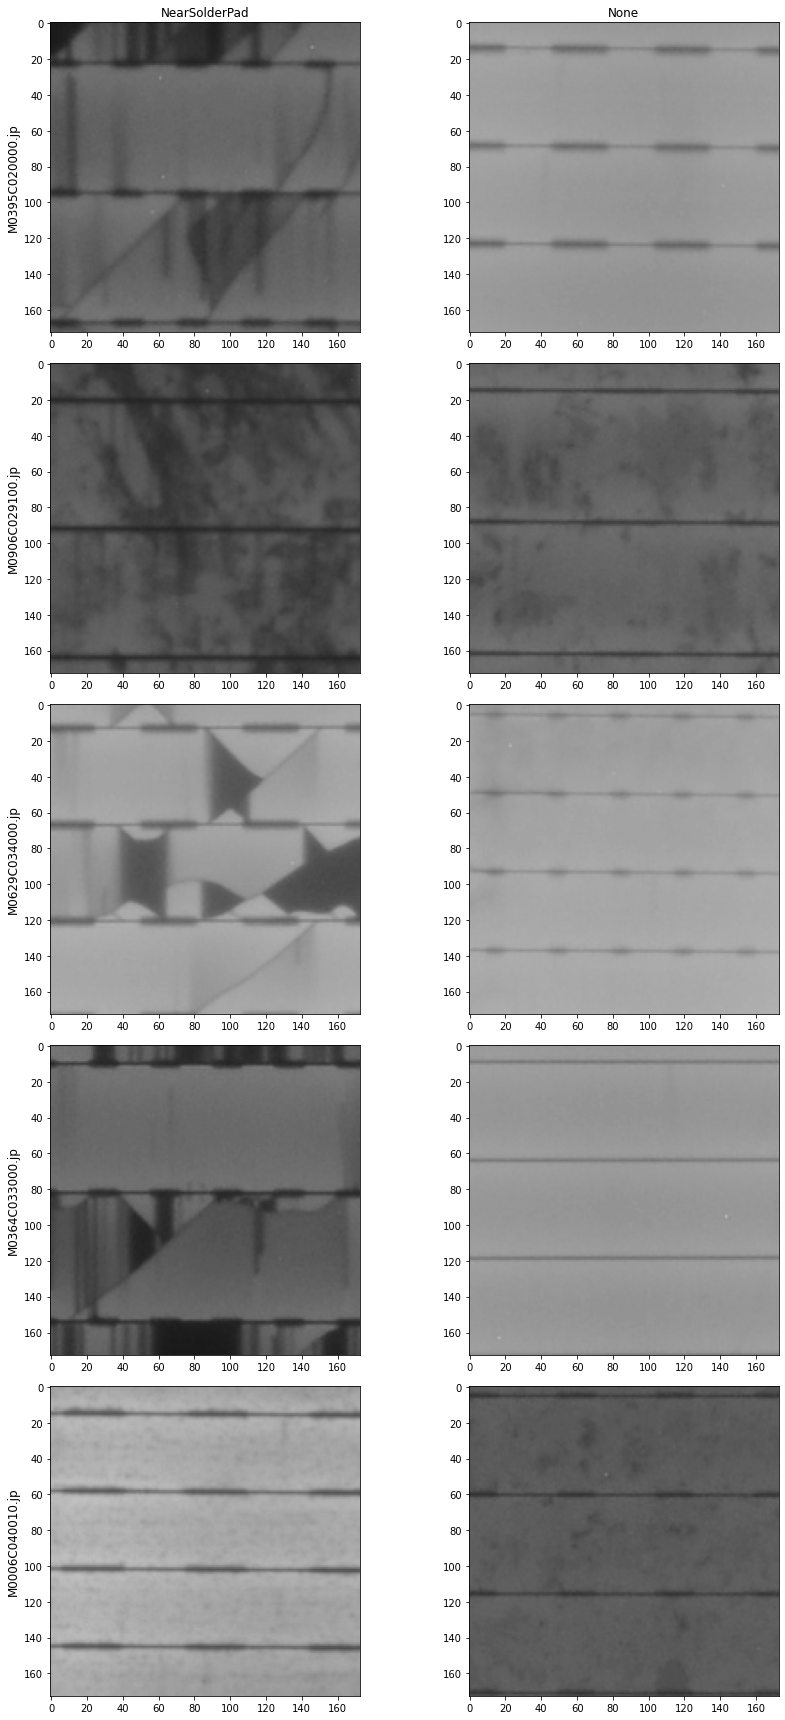

In [4]:
# # Load images and set them in four categories
num_samples = 500
iml = ImageLoader()
defect_categories = iml.defect_classes
defect_class='NearSolderPad'
not_defect_class = [x for x in defect_categories if x != defect_class]

defects = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=defect_class) << num_samples))
all_others = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=not_defect_class) << num_samples))
clean = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << num_samples))

single_defect = defects - all_others
single_defect.category = 'NearSolderPad'
clean.category = 'None'

# View both the defect and the clean class
_ = Show(num_images=5, seed=1234) << (single_defect, clean)

In [25]:
# Get the oriented images and HOG
start = time.perf_counter()
oriented_defect = Orient(num_jobs=20) << single_defect
oriented_clean = Orient(num_jobs=20) << clean
oriented_all_defects = Orient(num_jobs=20) << defects
oriented_all_others = Orient(num_jobs=20) << all_others
print(time.perf_counter() - start)
#_ = Show(num_images=5) << oriented_defect + oriented_clean

1306.5504054000048


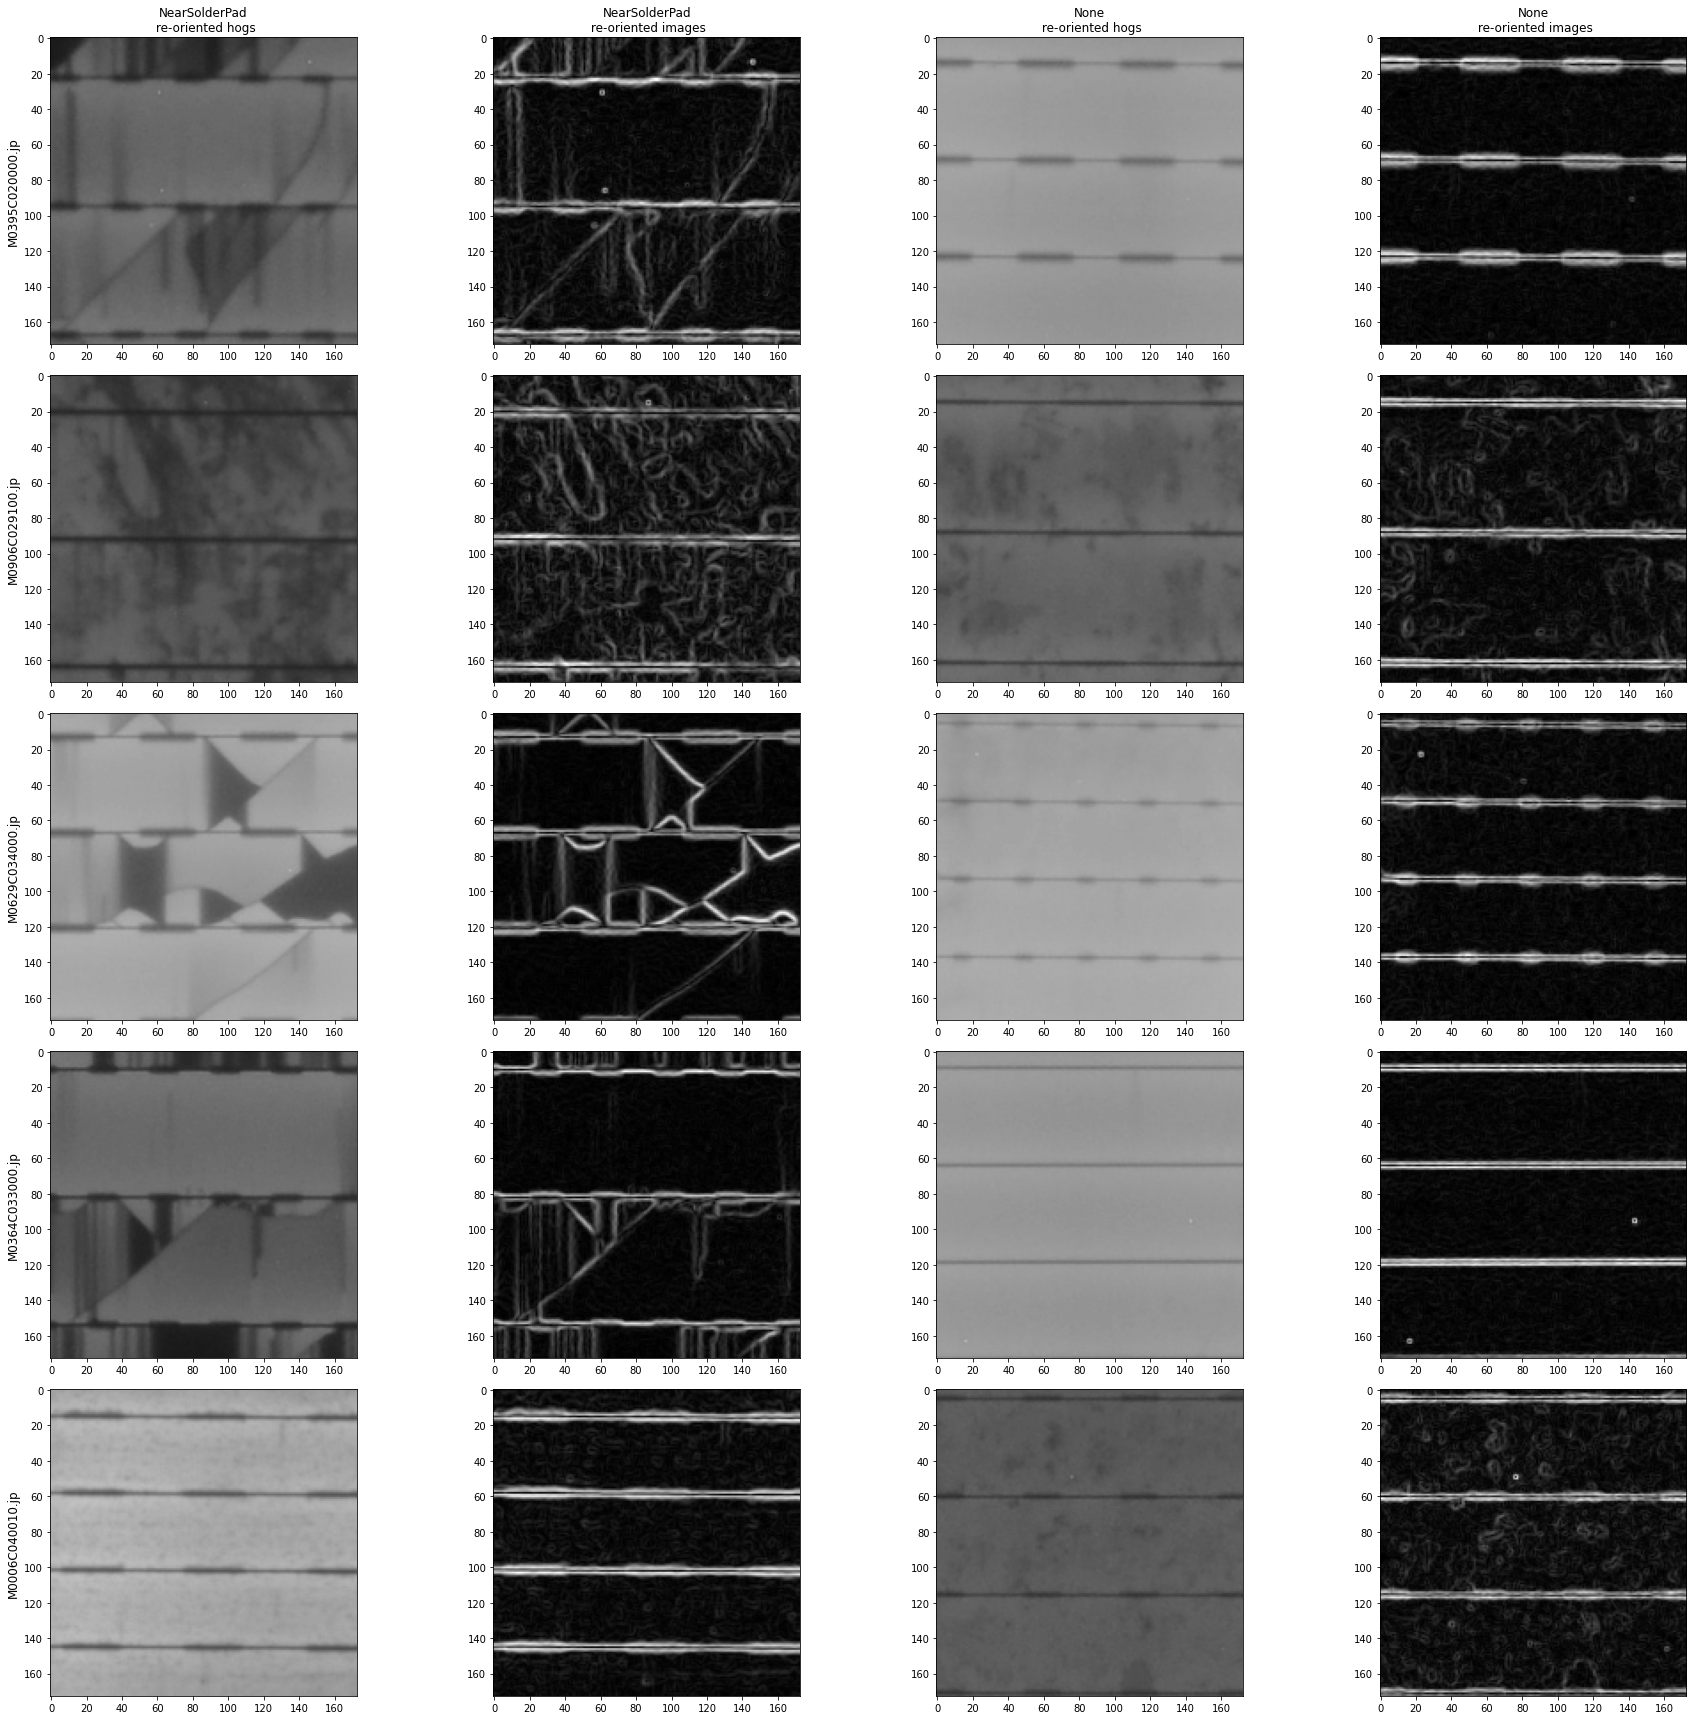

In [26]:
import copy

#Sobel Detection
x_imgs_clean = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << oriented_clean)
y_imgs_clean = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << oriented_clean)

x_imgs_defect = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << oriented_all_defects)
y_imgs_defect = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << oriented_all_defects) 

x_imgs_single = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << oriented_defect)
y_imgs_single = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << oriented_defect)

x_imgs_all_others = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << oriented_all_others)
y_imgs_all_others = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << oriented_all_others) 

cx_imgs_clean = x_imgs_clean[1].images
cy_imgs_clean = y_imgs_clean[1].images
c_imgs_clean  = np.empty([cx_imgs_clean.shape[0], cx_imgs_clean.shape[1], cx_imgs_clean.shape[2]],dtype=cx_imgs_clean.dtype)

cx_imgs_defect = x_imgs_defect[1].images
cy_imgs_defect = y_imgs_defect[1].images
c_imgs_defect = np.empty([cx_imgs_defect.shape[0], cx_imgs_defect.shape[1], cx_imgs_defect.shape[2]],dtype=cx_imgs_defect.dtype)

cx_imgs_single = x_imgs_single[1].images
cy_imgs_single = y_imgs_single[1].images
c_imgs_single = np.empty([cx_imgs_single.shape[0], cx_imgs_single.shape[1], cx_imgs_single.shape[2]],dtype=cx_imgs_single.dtype)

cx_imgs_all_others = x_imgs_all_others[1].images
cy_imgs_all_others = y_imgs_all_others[1].images
c_imgs_all_others = np.empty([cx_imgs_all_others.shape[0], cx_imgs_all_others.shape[1], cx_imgs_all_others.shape[2]],dtype=cx_imgs_all_others.dtype)


for img in range(len(c_imgs_clean)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_clean[img], cx_imgs_clean[img]), np.multiply(cy_imgs_clean[img], cy_imgs_clean[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_clean[img] = np.asarray(magnitude)  
    
for img in range(len(c_imgs_defect)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_defect[img], cx_imgs_defect[img]), np.multiply(cy_imgs_defect[img], cy_imgs_defect[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_defect[img] = np.asarray(magnitude)   
    
for img in range(len(c_imgs_single)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_single[img], cx_imgs_single[img]), np.multiply(cy_imgs_single[img], cy_imgs_single[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_single[img] = np.asarray(magnitude)   
    
for img in range(len(c_imgs_all_others)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_all_others[img], cx_imgs_all_others[img]), np.multiply(cy_imgs_all_others[img], cy_imgs_all_others[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_all_others[img] = np.asarray(magnitude)   

sobel_clean = copy.deepcopy(oriented_clean)   
sobel_single_defect = copy.deepcopy(oriented_defect)
sobel_defects = copy.deepcopy(oriented_all_defects)   
sobel_all_others = copy.deepcopy(oriented_all_others) 

sobel_clean[0].images = clean.images
sobel_defects[0].images = defects.images
sobel_single_defect[0].images = single_defect.images
sobel_all_others[0].images = all_others.images

sobel_clean[-1].images = c_imgs_clean
sobel_defects[-1].images = c_imgs_defect
sobel_single_defect[-1].images = c_imgs_single
sobel_all_others[-1].images = c_imgs_all_others

_ = Show(num_images=5, seed=1234) << sobel_single_defect + sobel_clean

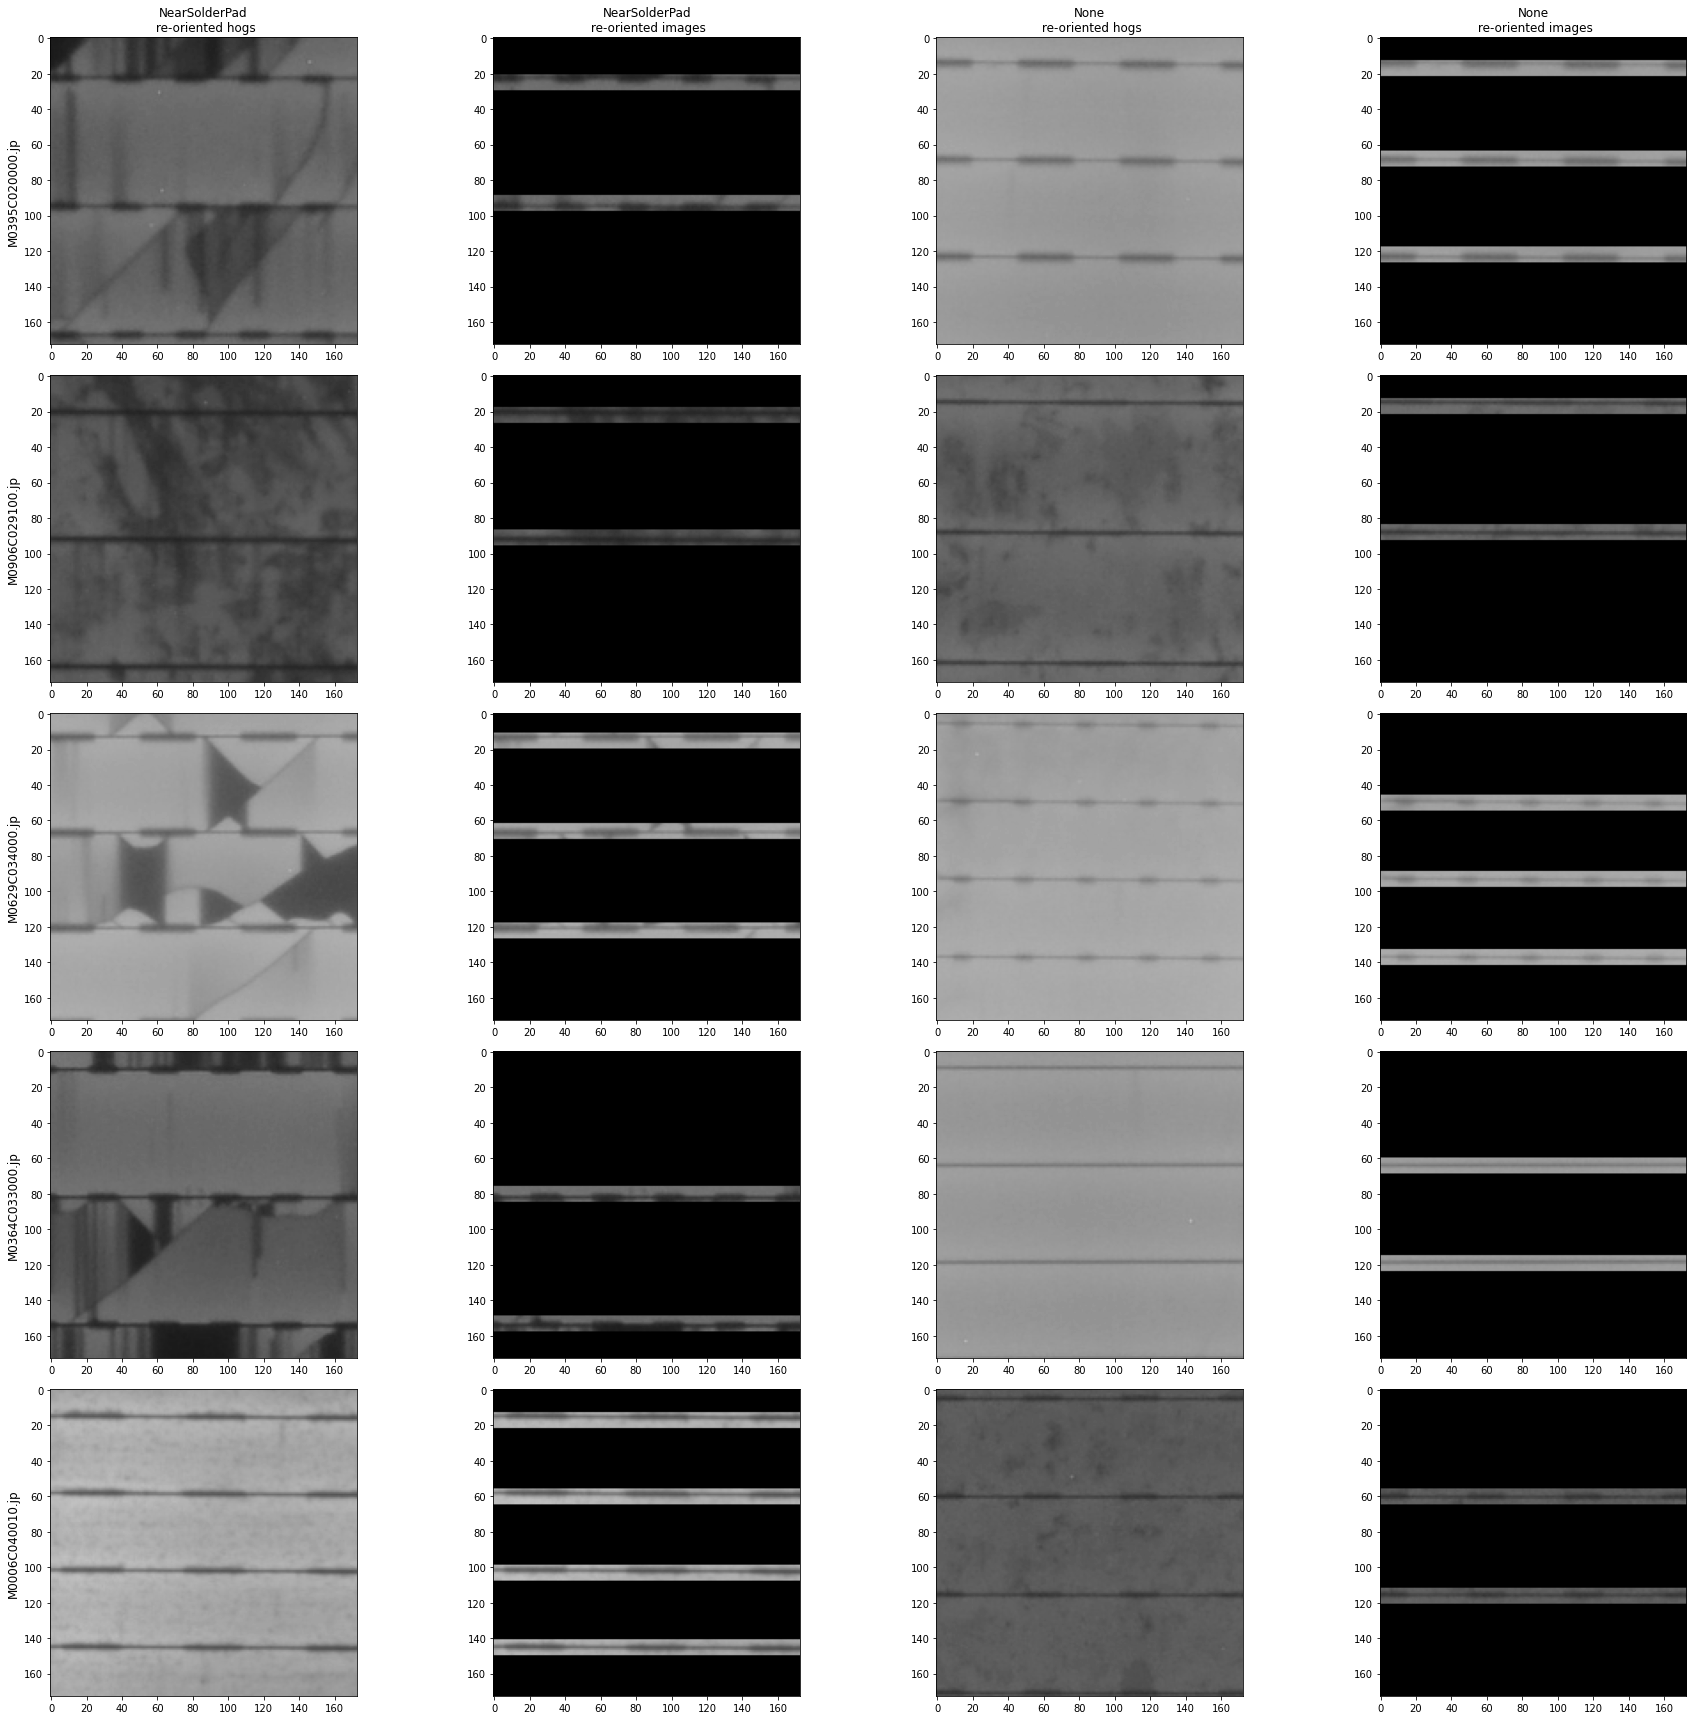

In [78]:
# Mask to just look at busbars
bus_defect_mask = BusbarMask(edge_buffer=15, min_spacing=30, broadening=4).apply(oriented_defect[-1].images)
bus_clean_mask = BusbarMask(edge_buffer=15, min_spacing=30, broadening=4).apply(oriented_clean[1].images)
bus_all_defects_mask = BusbarMask(edge_buffer=15, min_spacing=30, broadening=4).apply(oriented_all_defects[1].images)
bus_all_others_mask = BusbarMask(edge_buffer=15, min_spacing=30, broadening=4).apply(oriented_all_others[1].images)

bus_clean = oriented_clean
bus_defect = oriented_defect
bus_all_defects = oriented_all_defects
bus_all_others = oriented_all_others

bus_clean[0].images = clean.images
bus_all_defects[0].images = defects.images
bus_defect[0].images = single_defect.images
bus_all_others[0].images = all_others.images

bus_clean[-1].images = oriented_clean[0].images * bus_clean_mask
bus_all_defects[-1].images = oriented_all_defects[0].images * bus_all_defects_mask
bus_defect[-1].images = oriented_defect[0].images * bus_defect_mask
bus_all_others[-1].images = oriented_all_others[0].images * bus_all_others_mask

_ = Show(num_images=5, seed=1234) << bus_defect + bus_clean

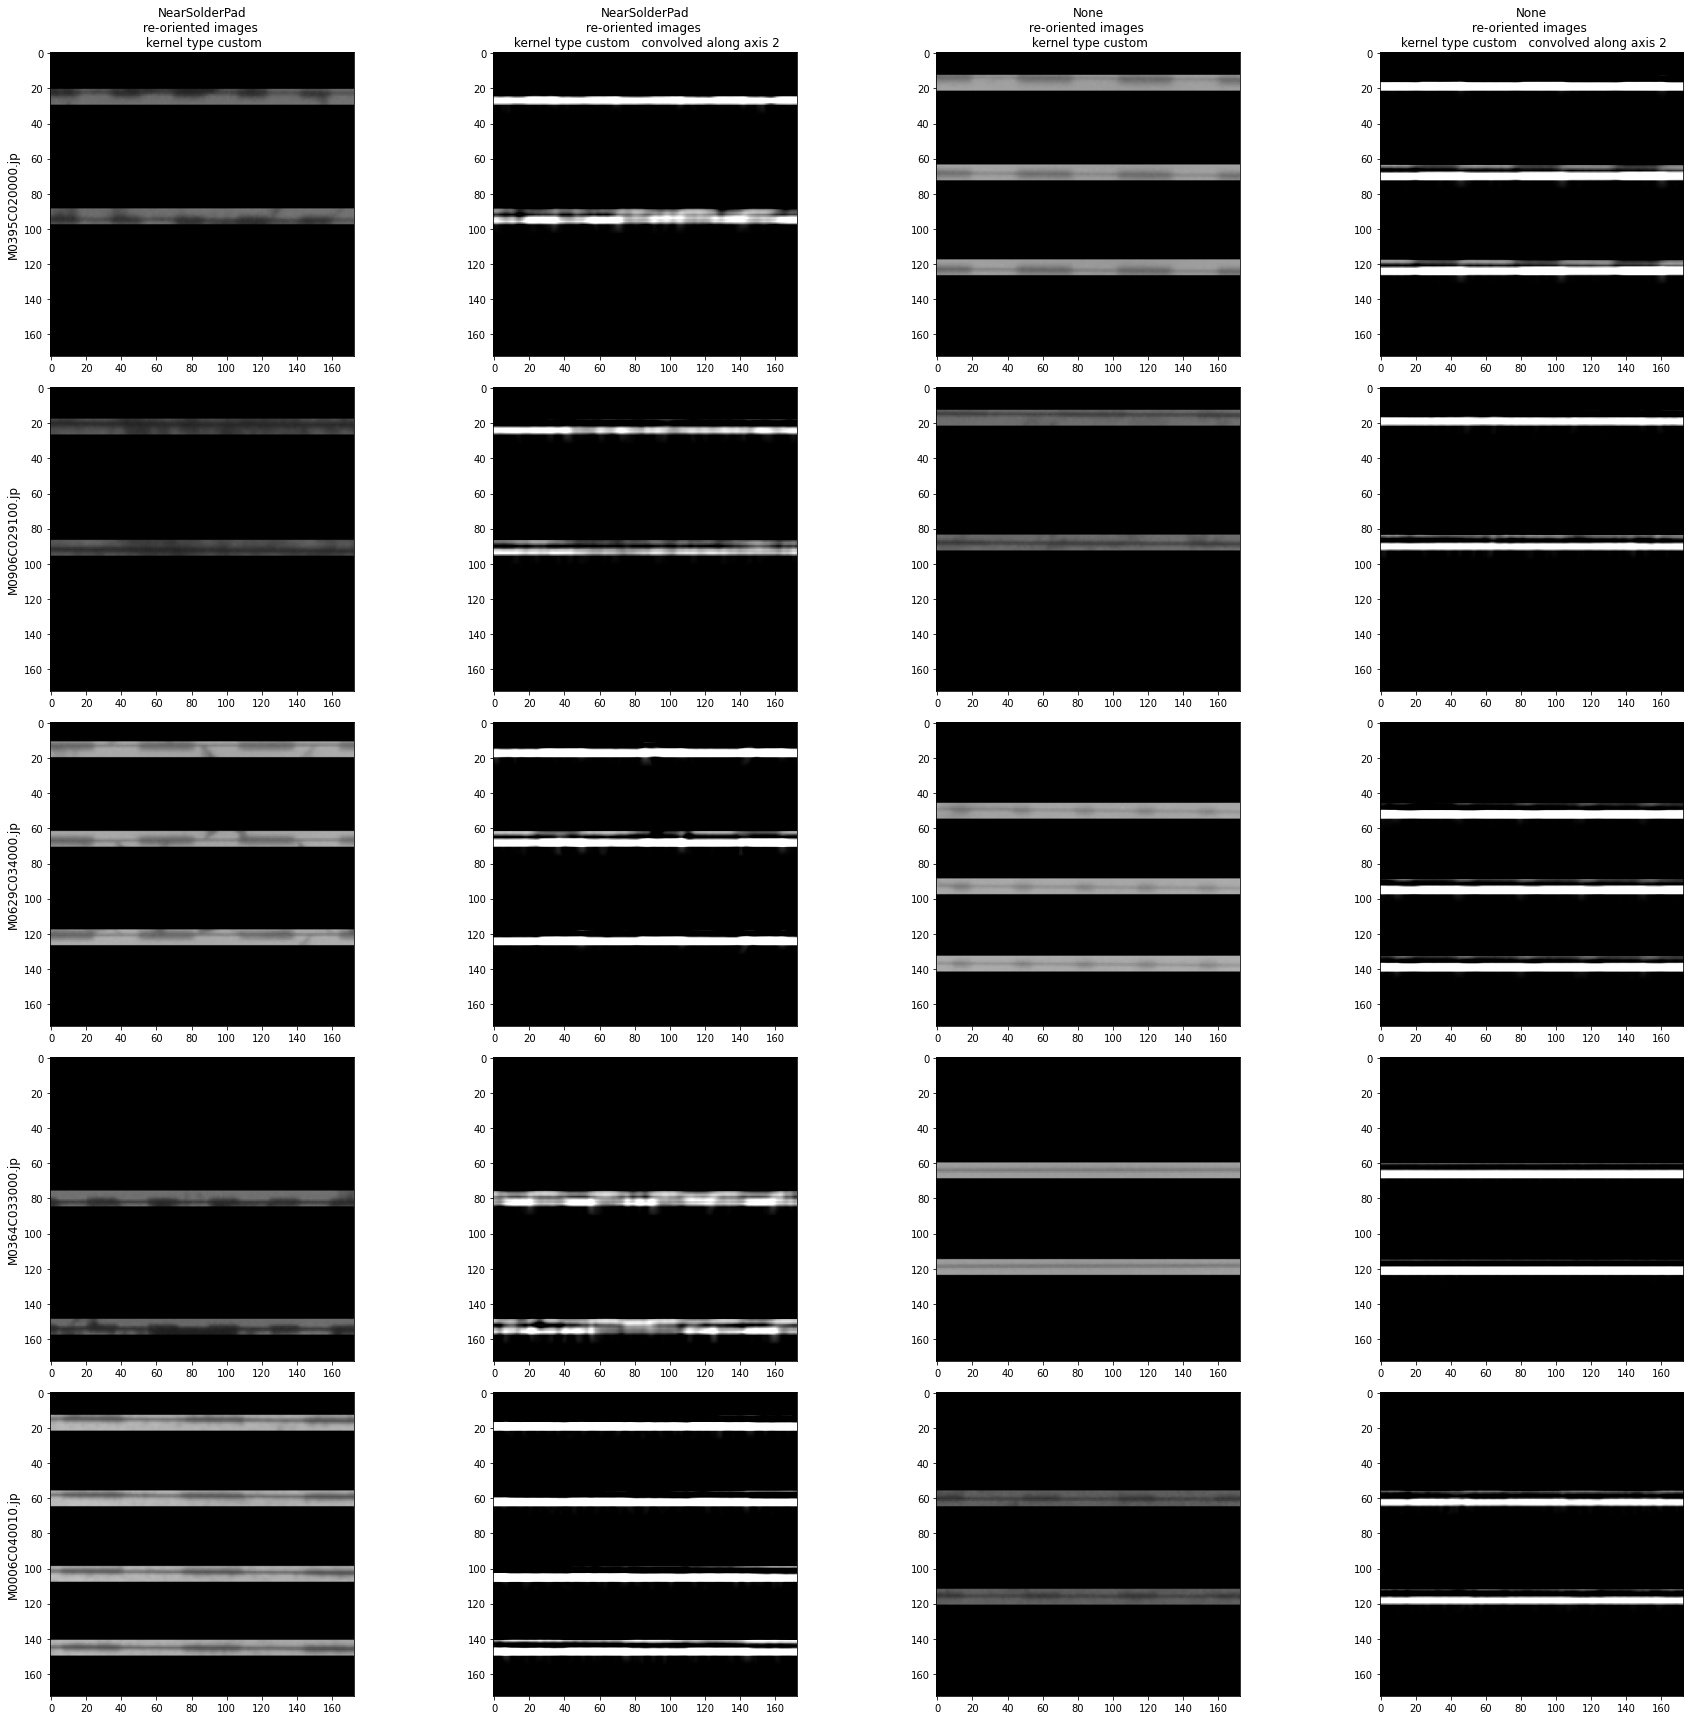

In [79]:
# T-Kernel on Image
t_kernel=np.array([[-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25 ],
                   [-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ],
                   [ 0.25,   0.0,   0.0,  0.25,   0.5,   0.5,  0.25 ],
                   [ 0.25,   0.0,   0.0,  0.25,   0.5,   0.5,  0.25 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ],
                   [  0.0, -0.25, -0.25,   0.0,  0.25,  0.25,   0.0 ]])

corner_clean = Convolve(axis=2) << (CreateKernel(kernel='custom', custom_kernel=t_kernel) << bus_clean)
corner_defect = Convolve(axis=2) << (CreateKernel(kernel='custom', custom_kernel=t_kernel) << bus_defect)
corner_all_defects = Convolve(axis=2) << (CreateKernel(kernel='custom', custom_kernel=t_kernel) << bus_all_defects)
corner_all_others = Convolve(axis=2) << (CreateKernel(kernel='custom', custom_kernel=t_kernel) << bus_all_others)

_ = Show(num_images=5, seed=1234) << corner_defect + corner_clean

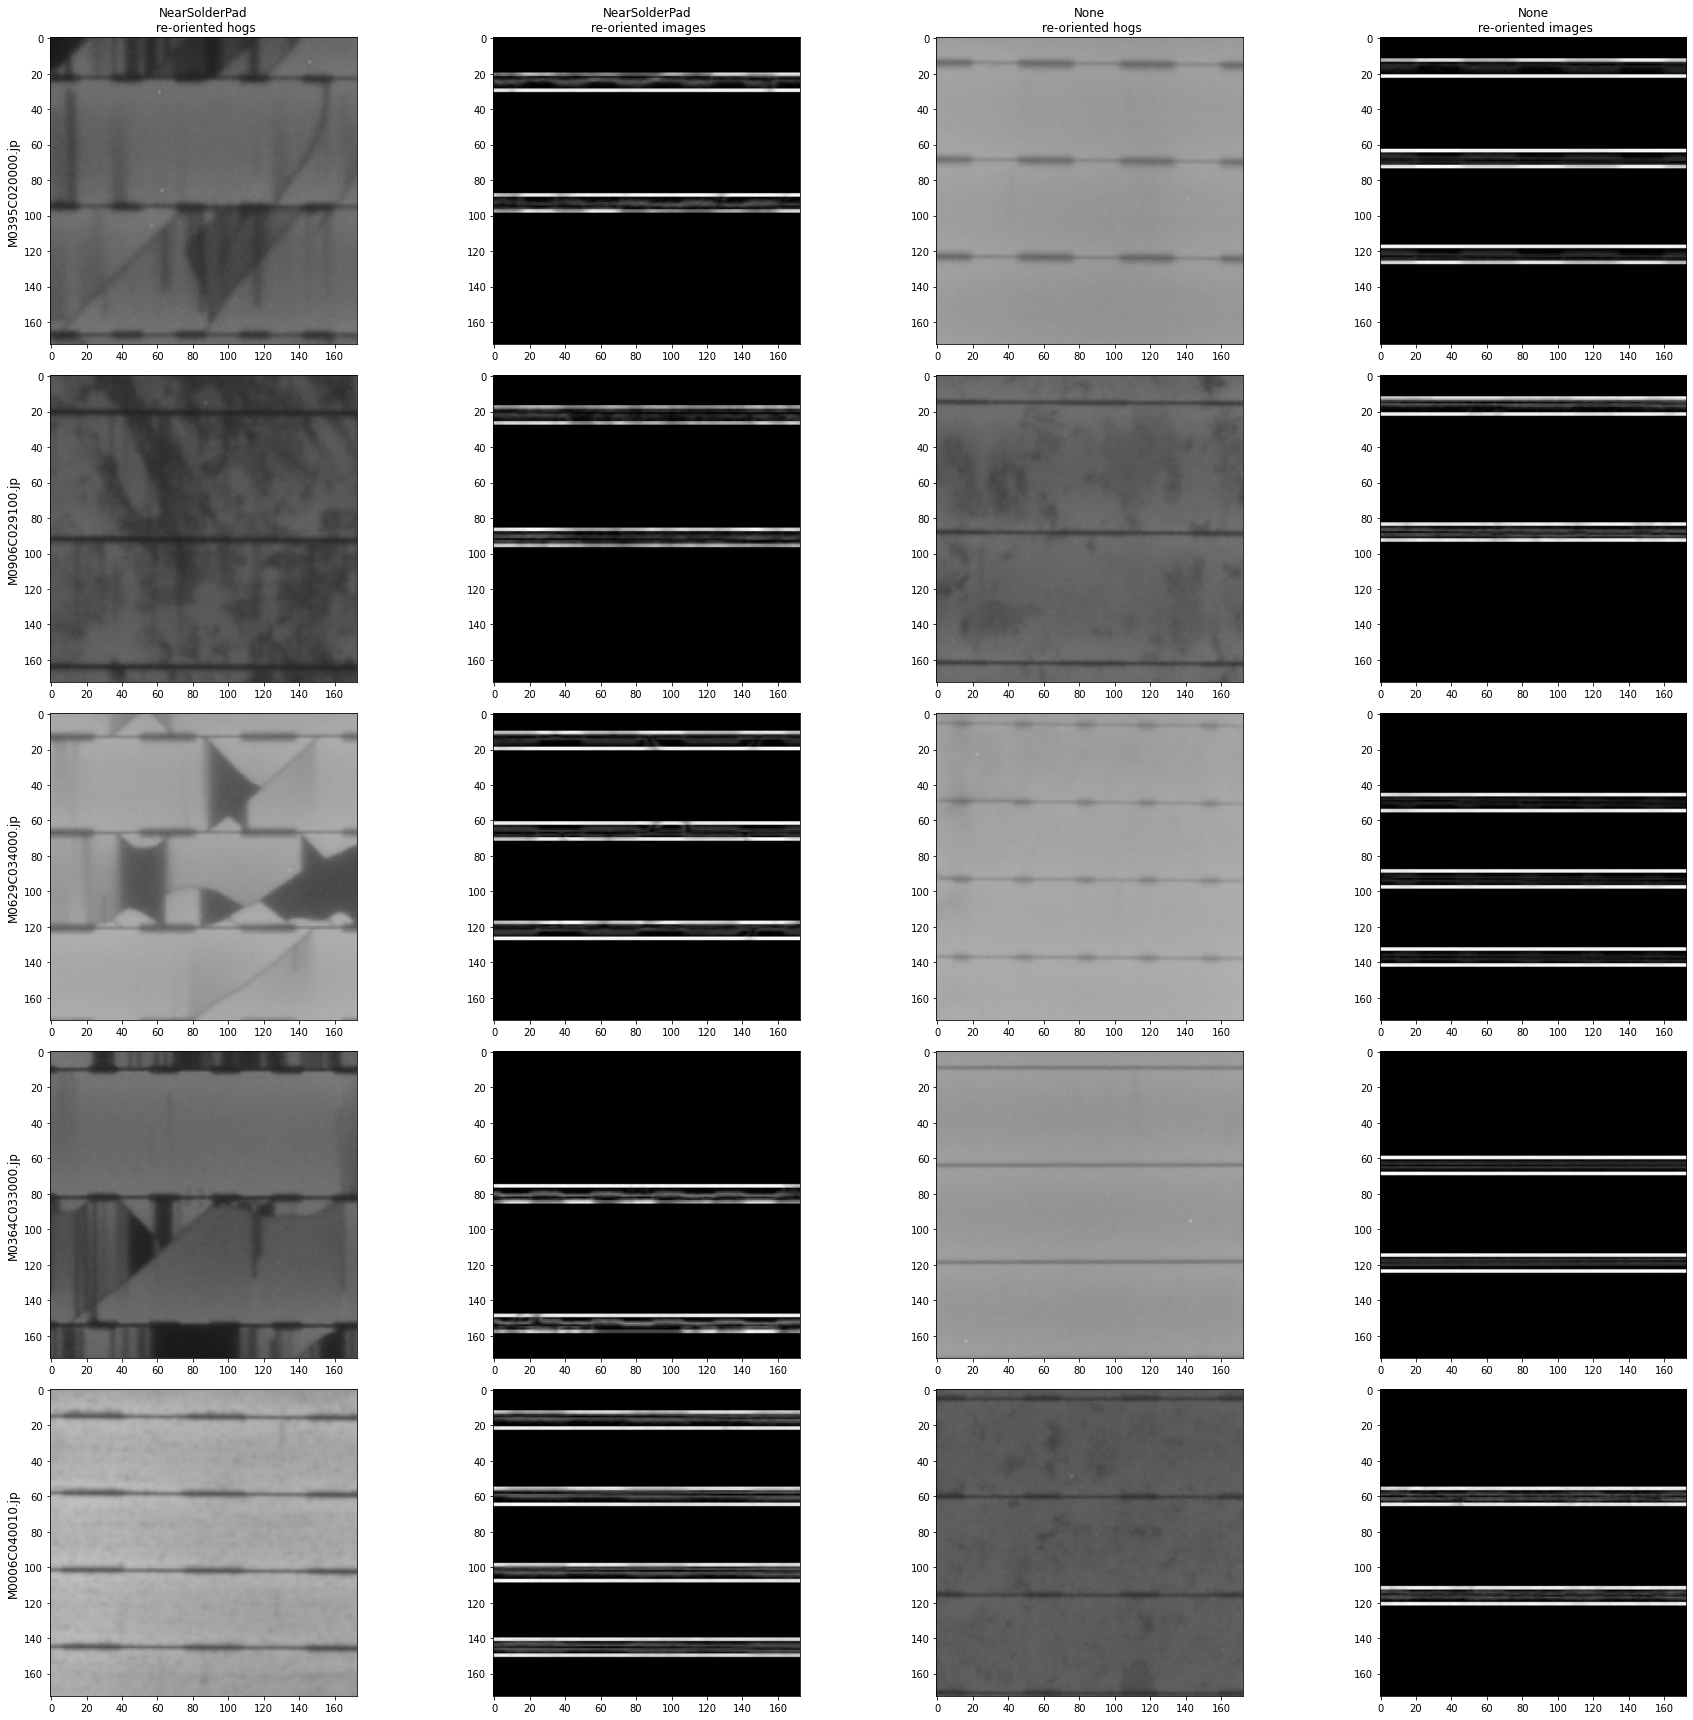

In [89]:
#Sobel Detection
x_imgs_clean = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << bus_clean)
y_imgs_clean = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << bus_clean)

x_imgs_defect = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << bus_all_defects)
y_imgs_defect = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << bus_all_defects) 

x_imgs_single = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << bus_defect)
y_imgs_single = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << bus_defect)

x_imgs_all_others = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << bus_all_others)
y_imgs_all_others = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << bus_all_others) 

cx_imgs_clean = x_imgs_clean[1].images
cy_imgs_clean = y_imgs_clean[1].images
c_imgs_clean  = np.empty([cx_imgs_clean.shape[0], cx_imgs_clean.shape[1], cx_imgs_clean.shape[2]],dtype=cx_imgs_clean.dtype)

cx_imgs_defect = x_imgs_defect[1].images
cy_imgs_defect = y_imgs_defect[1].images
c_imgs_defect = np.empty([cx_imgs_defect.shape[0], cx_imgs_defect.shape[1], cx_imgs_defect.shape[2]],dtype=cx_imgs_defect.dtype)

cx_imgs_single = x_imgs_single[1].images
cy_imgs_single = y_imgs_single[1].images
c_imgs_single = np.empty([cx_imgs_single.shape[0], cx_imgs_single.shape[1], cx_imgs_single.shape[2]],dtype=cx_imgs_single.dtype)

cx_imgs_all_others = x_imgs_all_others[1].images
cy_imgs_all_others = y_imgs_all_others[1].images
c_imgs_all_others = np.empty([cx_imgs_all_others.shape[0], cx_imgs_all_others.shape[1], cx_imgs_all_others.shape[2]],dtype=cx_imgs_all_others.dtype)


for img in range(len(c_imgs_clean)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_clean[img], cx_imgs_clean[img]), np.multiply(cy_imgs_clean[img], cy_imgs_clean[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_clean[img] = np.asarray(magnitude)  
    
for img in range(len(c_imgs_defect)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_defect[img], cx_imgs_defect[img]), np.multiply(cy_imgs_defect[img], cy_imgs_defect[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_defect[img] = np.asarray(magnitude)   
    
for img in range(len(c_imgs_single)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_single[img], cx_imgs_single[img]), np.multiply(cy_imgs_single[img], cy_imgs_single[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_single[img] = np.asarray(magnitude)   
    
for img in range(len(c_imgs_all_others)):
    magnitude = np.sqrt(np.add(np.multiply(cx_imgs_all_others[img], cx_imgs_all_others[img]), np.multiply(cy_imgs_all_others[img], cy_imgs_all_others[img])))
    magnitude = magnitude / np.max(magnitude)
    c_imgs_all_others[img] = np.asarray(magnitude)   

sobel_bus_clean = copy.deepcopy(bus_clean)   
sobel_bus_single_defect = copy.deepcopy(oriented_defect)
sobel_bus_defects = copy.deepcopy(oriented_all_defects)   
sobel_bus_all_others = copy.deepcopy(oriented_all_others) 

sobel_bus_clean[0].images = bus_clean[0].images
sobel_bus_defects[0].images = bus_all_defects[0].images
sobel_bus_single_defect[0].images = bus_defect[0].images
sobel_bus_all_others[0].images = bus_all_others[0].images

sobel_bus_clean[-1].images = c_imgs_clean
sobel_bus_defects[-1].images = c_imgs_defect
sobel_bus_single_defect[-1].images = c_imgs_single
sobel_bus_all_others[-1].images = c_imgs_all_others

_ = Show(num_images=5, seed=1234) << sobel_bus_single_defect + sobel_bus_clean

### Start Modeling

In [81]:
easy_scores = []
easy_titles = []

final_scores = []
final_titles = []

# Base model on raw data - single defect vs. clean
title = 'Base model single defect vs. clean'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(single_defect, clean, LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

easy_scores.append(score)
easy_titles.append(title)

# Misclassified
conf, out = cla.misclassified()
print(title)
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))



title = 'Base model all images with defect vs. rest of images'
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects, all_others, LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

final_scores.append(score)
final_titles.append(title)

# Misclassified
print(title)
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))



C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for: Base model single defect vs. clean   0.7413164665523155
Base model single defect vs. clean
          Pred 0    Pred 1
------  --------  --------
True 0        79         9
True 1        44        62
Score for: Base model all images with defect vs. rest of images   0.6851285189718482
Base model all images with defect vs. rest of images
          Pred 0    Pred 1
------  --------  --------
True 0        59        27
True 1        36        78


C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:

# Single defect vs. clean using Sobel Filter
title = 'Model Single defect vs. clean using Sobel Filter'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(sobel_single_defect[-1], sobel_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

easy_scores.append(score)
easy_titles.append(title)

# Misclassified
conf, out = cla.misclassified()
print(title)
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))



title = 'Model all images with defect vs. rest of images using Sobel Filter'
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(sobel_defects[-1], sobel_all_others[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

final_scores.append(score)
final_titles.append(title)

# Misclassified
print(title)
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for: Model Single defect vs. clean using Sobel Filter   0.7676886792452831
Model Single defect vs. clean using Sobel Filter
          Pred 0    Pred 1
------  --------  --------
True 0        77        11
True 1        36        70
Score for: Model all images with defect vs. rest of images using Sobel Filter   0.695328437372501
Model all images with defect vs. rest of images using Sobel Filter
          Pred 0    Pred 1
------  --------  --------
True 0        60        26
True 1        35        79


C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
# Single defect vs. clean using Busebar Masking + T-kernal Filter
title = 'Model Single defect vs. clean using Busbar Masking and T Filter'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(corner_defect[-1], corner_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

easy_scores.append(score)
easy_titles.append(title)

# Misclassified
conf, out = cla.misclassified()
print(title)
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


title = 'Model all images with defect vs. rest of images using Busbar Masking and T Filter'
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(corner_all_defects[-1], corner_all_others[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

final_scores.append(score)
final_titles.append(title)

# Misclassified
print(title)
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for: Model Single defect vs. clean using Busbar Masking and T Filter   0.7639365351629502
Model Single defect vs. clean using Busbar Masking and T Filter
          Pred 0    Pred 1
------  --------  --------
True 0        78        10
True 1        38        68
Score for: Model all images with defect vs. rest of images using Busbar Masking and T Filter   0.6923704610363117
Model all images with defect vs. rest of images using Busbar Masking and T Filter
          Pred 0    Pred 1
------  --------  --------
True 0        61        25
True 1        37        77


C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
# # Single defect vs. clean using Busebar Masking + Sobel Filter
# title = 'Model Single defect vs. clean using Busbar Masking and Sobel Filter'
# model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
# cla = Classifier(sobel_bus_single_defect[-1], sobel_bus_clean[-1], LogisticRegression, None)
# score = cla.fit(**model_params)
# print("Score for:", title, " ", score)

# easy_scores.append(score)
# easy_titles.append(title)

# # Misclassified
# conf, out = cla.misclassified()
# print(title)
# print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


title = 'Model all images with defect vs. rest of images using Busbar Masking and Sobel Filter'
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(sobel_bus_defects[-1], sobel_bus_all_others[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print("Score for:", title, " ", score)

final_scores.append(score)
final_titles.append(title)

# Misclassified
print(title)
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


Score for: Model all images with defect vs. rest of images using Busbar Masking and Sobel Filter   0.6805385556915544
Model all images with defect vs. rest of images using Busbar Masking and Sobel Filter
          Pred 0    Pred 1
------  --------  --------
True 0        65        21
True 1        45        69


C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Scores looking at singular defect vs. perfectly clean


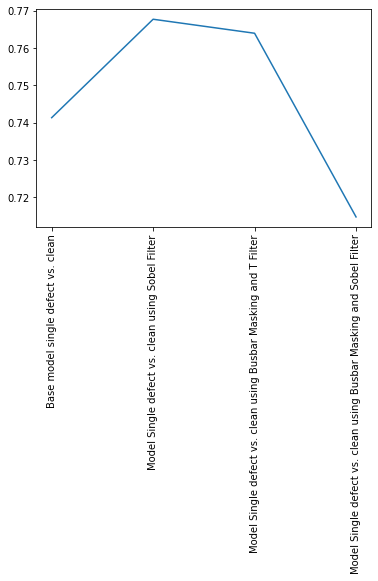

In [92]:
print("Scores looking at singular defect vs. perfectly clean")
x = np.arange(len(easy_scores))
y = np.array(easy_scores)
plt.xticks(x, easy_titles, rotation=90)
plt.plot(x, y, '-')
plt.show()

Scores looking at if defect appears vs. does not appear


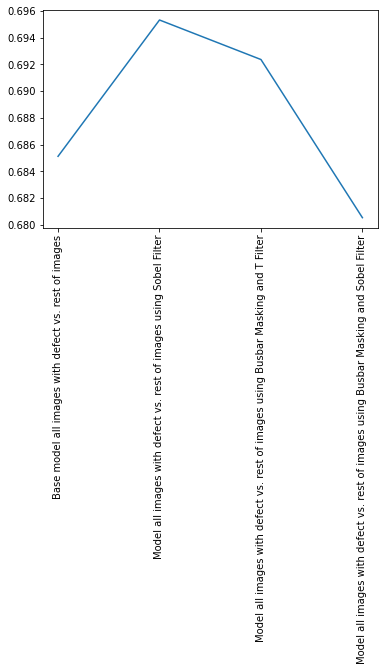

In [93]:
print("Scores looking at if defect appears vs. does not appear")
x = np.arange(len(final_scores))
y = np.array(final_scores)
plt.xticks(x, final_titles, rotation=90)
plt.plot(x, y, '-')
plt.show()